In [1]:
import sys 
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/neuralssm/src/neuralssm')
from jax import numpy as jnp # type: ignore
from jax import random as jr # type: ignore
from jax.scipy.special import factorial as fac # type: ignore
from util.bijectors import RealToPSDBijector # type: ignore
from simulators.ssm import SPN, LGSSM
from util.param import sample_prior, initialize
import tensorflow_probability.substrates.jax.distributions as tfd # type: ignore
import tensorflow_probability.substrates.jax.bijectors as tfb # type: ignore

import scienceplots # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib_inline # type: ignore
plt.style.use(['science', 'ieee'])
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Setup

### SSM parameters

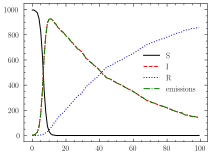

In [2]:
from simulators.sirssm import setup

sim_setup = setup(3, 1, 0, [])
spn = sim_setup['ssm']
props = sim_setup['props']
inputs = sim_setup['inputs']
param_names = sim_setup['exp_info']['param_names']
is_constrained_tree = sim_setup['exp_info']['constrainers']

key = jr.PRNGKey(0)
key, subkey = jr.split(key)
xparam = sample_prior(subkey, props)[0]

key, subkey = jr.split(jr.PRNGKey(0))
params = sample_prior(subkey, props, 100)[0]
key, subkey = jr.split(key)
num_timesteps = 100
states, emissions = spn.simulate(subkey, params, num_timesteps)

plt.plot(states[:, 0], label = 'S')
plt.plot(states[:, 1], label = 'I')
plt.plot(states[:, 2], label = 'R')
plt.plot(emissions, label = 'emissions')
plt.legend()
plt.show()

In [ ]:
from jax.scipy.special import gammaln, logsumexp as lse
from jax import vmap, jit

log_bin = jit(lambda N, k: gammaln(N + 1) - gammaln(k + 1) - gammaln(N - k + 1))
sum_log_bin = lambda x, n: jnp.sum(vmap(log_bin)(x, n))
log_bin_hazard_fn = lambda state, pre, log_rates: vmap(lambda row, log_rate: log_rate + sum_log_bin(state, row))(pre, log_rates)

def log_hazard_fn(state, pre, log_rates): 

    return log_bin_hazard_fn(state, pre, log_rates)

state = jnp.array([0., 170.94934, 830.16364])
lh = log_hazard_fn(state, params.dynamics.pre.value, params.dynamics.log_rates.value)

lh0 = lse(lh)
dt = tfd.Exponential(jnp.exp(lh0)).sample(seed=subkey)
lh -= jnp.max(lh)
prob_vec = jnp.exp(lh) / jnp.sum(jnp.exp(lh))

key, subkey = jr.split(key)
event = tfd.Categorical(probs=prob_vec).sample(seed=subkey)

event

Array(1, dtype=int32)

: 

### Sample emissions and states

In [4]:
key, subkey = jr.split(jr.PRNGKey(315520))
true_lgssm = LGSSM(state_dim, emission_dim)
[true_params, example_param] = sample_ssm_params(key, prior, 2)
true_params.from_unconstrained(props)
states, emissions = true_lgssm.simulate(subkey, true_params, num_timesteps)

plt.plot(emissions)
plt.show()

NameError: name 'state_dim' is not defined

## Inference

### Likelihood approximation

In [ ]:
# covs = []
# params_list = []
# for param in sample_ssm_params(key, prior, 100):
#     param.from_unconstrained(props)
#     params_list.append(param)
#     covs.append(param.dynamics.cov.value)
# thetas = jnp.array(covs).flatten()
# # thetas = jnp.sort(thetas)
# # BPF
# num_particles = 1000
# num_iters = 1
# lls = []
# for param in params_list:
#     ll = 0
#     for _ in range(num_iters):
#         _, ll_i = bpf(param, true_lgssm, emissions, num_particles, key)
#         ll += ll_i/num_iters 
#     lls.append(ll)
# lls = jnp.array(lls)
# # plt.scatter(thetas, lls)
# # plt.show()

### Posterior sampling with BlackJax

In [ ]:
import blackjax
from datetime import date
from parameters import log_prior, get_unravel_fn, join_trees, tree_from_params, to_train_array

# Define test-model (SSM) and log-density function
lgssm = LGSSM(state_dim, emission_dim)

def logdensity_fn(cond_params):
    unravel_fn = get_unravel_fn(example_param, props)
    unravel = unravel_fn(cond_params)
    tree = tree_from_params(example_param)
    new_tree = join_trees(unravel, tree, props)
    params = params_from_tree(new_tree, param_names, is_constrained_tree)
    params.from_unconstrained(props)
    _, lp = bpf(params, lgssm, emissions, num_particles, key)
    lp += log_prior(cond_params, prior)
    return jnp.mean(lp)

# Initialize MCMC chain and kernel
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
initial_cond_params = to_train_array(sample_ssm_params(rng_key, prior, 1)[0], props)
random_walk = blackjax.additive_step_random_walk(logdensity_fn, blackjax.mcmc.random_walk.normal(0.1))
initial_state = random_walk.init(initial_cond_params)
kernel = jax.jit(random_walk.step)

# Define inference loop
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

# Run inference loop
rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop(sample_key, kernel, initial_state, 2_000)

In [ ]:
import jax.scipy.stats as jss
kernel_points = states.position[-100:].T
posterior_mean = jnp.mean(kernel_points, axis=1)
kde = jss.gaussian_kde(kernel_points, bw_method=1.0)
min = jnp.min(kernel_points[0, :])
max = jnp.max(kernel_points[0, :])

eval_points_at_dim = jnp.linspace(min, max, 100)
eval_points = jnp.concatenate([eval_points_at_dim[None].T, jnp.tile(posterior_mean[1:], (100, 1))], axis=1)
density_evals = kde.evaluate(eval_points.T)

plt.plot(eval_points_at_dim, density_evals)
plt.vlines(kernel_points[0, :], jnp.min(density_evals), jnp.max(density_evals), color='red', alpha=0.1)
plt.show()
plt.hist(kernel_points[0, :], bins=50, density=True)
plt.show()
# print(-jnp.log(kde.evaluate(RealToPSDBijector().inverse(true_params.dynamics.cov.value))))

In [ ]:
density_evals